In [ ]:
'''
  Faces from OMG dataset training and validation videos have been extracted previously
'''

##imports and setup
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras.backend as KB
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import cv2 as cv
import keras
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

#mount drive:
#from google.colab import drive
#drive.mount('/content/drive')
print('Completed')

Completed


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/omg/Validation_images.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Validation_images/e3b57cfd8_5_utterance_71_220.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_221.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_222.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_223.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_224.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_225.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_226.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_227.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_228.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_229.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_23.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_230.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_231.jpg  
  inflating: Validation_images/e3b57cfd8_5_utterance_71_232.jpg  
  inflating: Val

In [ ]:
'''
Run the next code for validation of the saved model
'''
##Loading model
model = keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/omg/Albertss_final.h5', compile=False)
print('completed')

completed


In [ ]:
# Load the previously saved weights
PATH_WEIGHTS="/content/drive/MyDrive/Colab_Notebooks/omg/Alberts_weights_final.h5"
model.load_weights(PATH_WEIGHTS)
print('completed')

completed


In [ ]:
test_faces = np.load("/content/drive/MyDrive/Colab_Notebooks/omg/valid_faces_omg.npy")
test_labels = np.load("/content/drive/MyDrive/Colab_Notebooks/omg/valid_cont_omg.npy")
tests = []
path = "/content/Validation_images/"

for image in os.listdir(path):
  img = cv.imread(path+image, cv.IMREAD_UNCHANGED)
  resized = cv.resize(img, (64, 64))
  tests.append(resized)

test_faces = np.asarray(tests)

print(test_faces.shape)
print(test_labels.shape)

(54557, 64, 64, 3)
(54557, 2)


In [ ]:
# Normalize images and save values for 1 utterance
test_faces = test_faces[0:242] / 255
test_labels = test_labels[0:242]

In [ ]:
# Normalize images and save values for 1 utterance
test_faces = test_faces[::5] / 255
test_labels = test_labels[::5]

In [ ]:
print(test_faces.shape)
print(test_labels.shape)

(10912, 64, 64, 3)
(10912, 2)


In [ ]:
#Setup moving average
import numpy as np
class VA_FILTER:
  def __init__(self,N=10):
    self.N = N
    self.valence_array=[]
    self.arousal_array=[]
  def update_va(self,pred):
    self.valence_array.append(pred[0][1])
    self.arousal_array.append(pred[0][0])
    if len(self.valence_array)>=10:
        valence=np.convolve(self.valence_array, np.ones(self.N) / self.N, mode='valid')[0]
        arousal=np.convolve(self.arousal_array, np.ones(self.N) / self.N, mode='valid')[0]
        self.valence_array=self.valence_array[1:]
        self.arousal_array=self.arousal_array[1:]
    else:
        valence=pred[0][1]
        arousal=pred[0][0]
    return np.asarray((arousal,valence))

In [ ]:
# Sanity check
# Compute the predictions manually for just 1 utterance in the valence and the arousal space and plot it against the real labels

va_filter = VA_FILTER(50)
results_valence = []
results_arousal = []
temp = []

for face in test_faces:
  result = model.predict(face[None,...], verbose=0)
  #results_valence.append((result[0][1]*2)-1)
  #results_arousal.append((result[0][0]*2)-1)
  pred = va_filter.update_va(result)
  temp.append(pred)

plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(temp[:, 0])
plt.plot(test_labels[:, 0])
plt.title('Arousal predictions')
plt.xlabel('Frames')
plt.ylabel('Values')
plt.legend(['Moving average prediction', 'Label'], loc='upper left')
plt.rcParams['figure.dpi'] = 300
plt.savefig("/content/drive/MyDrive/Colab_Notebooks/arousalSC_3.png")
plt.show()

plt.plot(temp[:, 1])
plt.plot(test_labels[:, 1])
plt.title('Valence predictions')
plt.xlabel('Frames')
plt.ylabel('Values')
plt.legend(['Moving average prediction', 'Label'], loc='upper left')
plt.rcParams['figure.dpi'] = 300
plt.savefig("/content/drive/MyDrive/Colab_Notebooks/valenceSC_3.png")
plt.show()

KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import train_test_split

# Shuffling the validation data
x_train, x_valid, y_train, y_valid = train_test_split(test_faces, test_labels, test_size=0.01, shuffle=True)

In [ ]:
results = model.evaluate(x=x_train, y=y_train, batch_size=64)
print("test loss, test ccc_a, test ccc_v:", results)

422/422 [==============================] - 15s 33ms/step - loss: 1.0000 - ccc_a: 0.0017 - ccc_v: -0.0017
test loss, test ccc_a, test ccc_v: [0.9988743662834167, 0.0018259573262184858, 0.00042247920646332204]


In [ ]:
'''
Run the next code in case training needs to be done 
'''

!unzip /content/drive/MyDrive/Colab_Notebooks/omg/Images.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Images/f8da01d25_2_utterance_43_41.jpg  
  inflating: Images/f8da01d25_2_utterance_43_42.jpg  
  inflating: Images/f8da01d25_2_utterance_43_43.jpg  
  inflating: Images/f8da01d25_2_utterance_43_44.jpg  
  inflating: Images/f8da01d25_2_utterance_43_45.jpg  
  inflating: Images/f8da01d25_2_utterance_43_46.jpg  
  inflating: Images/f8da01d25_2_utterance_43_47.jpg  
  inflating: Images/f8da01d25_2_utterance_43_48.jpg  
  inflating: Images/f8da01d25_2_utterance_43_49.jpg  
  inflating: Images/f8da01d25_2_utterance_43_5.jpg  
  inflating: Images/f8da01d25_2_utterance_43_50.jpg  
  inflating: Images/f8da01d25_2_utterance_43_51.jpg  
  inflating: Images/f8da01d25_2_utterance_43_52.jpg  
  inflating: Images/f8da01d25_2_utterance_43_53.jpg  
  inflating: Images/f8da01d25_2_utterance_43_54.jpg  
  inflating: Images/f8da01d25_2_utterance_43_55.jpg  
  inflating: Images/f8da01d25_2_utterance_43_56.jpg  
  inflating: Images/f8

In [ ]:
train_faces1 = []
#aux = 0

p = '/content/Images/'

#Loading the data into the correct format:
for img in os.listdir(p):
  image = cv.imread(p+img, cv.IMREAD_UNCHANGED)
  new_arr = cv.resize(image, (128, 128))
  train_faces1.append(new_arr)
  del image

train_faces = np.asarray(train_faces1)
train_faces = train_faces.reshape(train_faces.shape[0], 128, 128, 3)
print('completed')

In [ ]:
#Loading annotations:
data_src = '/content/drive/MyDrive/Colab_Notebooks/omg'
train_data = []

dir = os.path.join(data_src, "va.txt")
with open (dir, "r") as myfile:
    string_data = myfile.read()

list_data = string_data.splitlines()
list_data.pop()
new_list = []

for data in list_data:
  new_list.append(data.split(','))

new2_list = []
for newData in new_list:
  file = newData[0]+"_"+newData[1]+"_"+newData[2]+".jpg"
  arousal = (float(newData[3]) + 1) / 2
  valence = (float(newData[4]) + 1) / 2
  train_data.append([file, arousal, valence])

#train_cont = np.array(new2_list, dtype=float)
print('completed')

completed


In [ ]:
dfTrain = pd.DataFrame(train_data, columns=['path', 'aro', 'val'])
print(dfTrain.tail())

                                    path       aro       val
278759  f8da01d25_2_utterance_99_104.jpg  0.594036  0.314807
278760  f8da01d25_2_utterance_99_105.jpg  0.594036  0.314807
278761  f8da01d25_2_utterance_99_106.jpg  0.594036  0.314807
278762  f8da01d25_2_utterance_99_107.jpg  0.594036  0.314807
278763  f8da01d25_2_utterance_99_108.jpg  0.594036  0.314807


In [ ]:
print(dfTrain)

                                    path       aro       val
0          04899849f_1_utterance_1_0.jpg  0.768631  0.425980
1          04899849f_1_utterance_1_1.jpg  0.768631  0.425980
2          04899849f_1_utterance_1_2.jpg  0.768631  0.425980
3          04899849f_1_utterance_1_3.jpg  0.768631  0.425980
4          04899849f_1_utterance_1_4.jpg  0.768631  0.425980
...                                  ...       ...       ...
278759  f8da01d25_2_utterance_99_104.jpg  0.594036  0.314807
278760  f8da01d25_2_utterance_99_105.jpg  0.594036  0.314807
278761  f8da01d25_2_utterance_99_106.jpg  0.594036  0.314807
278762  f8da01d25_2_utterance_99_107.jpg  0.594036  0.314807
278763  f8da01d25_2_utterance_99_108.jpg  0.594036  0.314807

[278764 rows x 3 columns]


In [ ]:
BATCH_SIZE = 64
train=ImageDataGenerator(rescale=1./255., 
                         zoom_range=0.2,
                        horizontal_flip=True,
                         validation_split=0.2,)
train_generator=train.flow_from_dataframe(dataframe=dfTrain,
                                            directory="/content/Images",
                                            x_col="path",
                                            y_col=["aro", "val"],
                                            subset="training",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            shuffle=False,
                                            class_mode="raw",
                                            target_size=(64,64))

validation_generator=train.flow_from_dataframe(dataframe=dfTrain,
                                            directory="/content/Images",
                                            x_col="path",
                                            y_col=["aro", "val"],
                                            subset="validation",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            shuffle=False,
                                            class_mode="raw",
                                            target_size=(64,64))

Found 223012 validated image filenames.
Found 55752 validated image filenames.


In [ ]:
'''
np.save('train_faces_color', train_faces)
np.save('train_cont_color', train_cont)

In [ ]:
'''
path = '/content/drive/MyDrive/Colab_Notebooks/omg'

train_faces = np.load(os.path.join(path, 'train_faces_color.npy'))
train_cont = np.load(os.path.join(path, 'train_cont_color.npy'))

print(train_faces.shape)
print(train_cont.shape)

(12000, 128, 128, 1)
(12000, 2)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


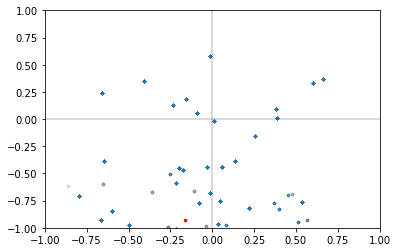

In [ ]:
#dataset investigation
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.axhline(y=0, color='k',linewidth=0.3)
ax.axvline(x=0, color='k',linewidth=0.3)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.scatter(train_cont[:,0]*2-1,train_cont[:,1]*2-1,s=7,alpha=0.01)
ax.scatter(np.mean(train_cont[:,0])*2-1,np.mean(train_cont[:,1])*2-1,s=7,c=(1,0,0))
fig.show()

In [ ]:
### model setup
#data size 128
IMG_SIZE = 64
IMG_DIM = 3

def model_vgg13_custom(output_classes=2):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DIM)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Faltten the model
    model.add(Flatten())

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    #Sigmoid Activation function
    model.add(Dense(output_classes, activation='sigmoid'))
    #Mean Squared Error loss function The metric must be different in regression cases.

    #print(model.summary())
    return model
model=model_vgg13_custom()
print('completed')

completed


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       7

In [ ]:
## Implementing the CCC Loss function:
import tensorflow.keras.backend as K

def ccc_loss(y_true, y_pred):
    return 1 - ((ccc_v(y_true, y_pred) + ccc_a(y_true, y_pred)) / 2)


def ccc_v(y_true, y_pred):
    """
    Concordance Correlation Coefficient for valence
    """
    x = y_true[:, 1]
    y = y_pred[:, 1]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc


def ccc_a(y_true, y_pred):
    """
    Concordance Correlation Coefficient for arousal
    """
    x = y_true[:, 0]
    y = y_pred[:, 0]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc

opt = Adam(lr=0.0001, decay=1e-6)
#Selecting loss and metrics
model.compile(optimizer=opt, loss=ccc_loss, metrics=[ccc_a, ccc_v])

print('completed')

completed


In [ ]:
###making the training ready
chk_path = '/content/drive/MyDrive/Colab_Notebooks/omg/Albertss_final2.h5'
log_dir = "/content/drive/MyDrive/Colab_Notebooks/omg/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                               save_best_only=True,
                               verbose=1,
                               mode='min',
                               moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=6,
                                verbose=1,
                                min_delta=0.0001)

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab_Notebooks/omg/Alberts_final2.log')

callback = [checkpoint, reduce_lr, csv_logger]
print(steps_per_epoch)
print(validation_steps)

print('completed')

3484
871
completed


In [ ]:
with tf.device('/device:GPU:0'):
  epochs=25
  model_hist = model.fit_generator(generator=train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=callback,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)
save_path = '/content/drive/MyDrive/Colab_Notebooks/omg/Alberts_weights_final2.h5'
model.save_weights(save_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
3484/3484 [==============================] - 721s 197ms/step - loss: nan - ccc_a: nan - ccc_v: nan - val_loss: nan - val_ccc_a: nan - val_ccc_v: nan

Epoch 00001: val_loss did not improve from inf
Epoch 2/25
 125/3484 [>.............................] - ETA: 8:07 - loss: nan - ccc_a: nan - ccc_v: nan

KeyboardInterrupt: ignored

In [ ]:
save_path = '/content/drive/MyDrive/Colab_Notebooks/omg/Alberts_weights_final.h5'
model.save_weights(save_path)

In [ ]:
model.history.history.keys()

dict_keys(['loss', 'ccc_a', 'ccc_v', 'val_loss', 'val_ccc_a', 'val_ccc_v', 'lr'])

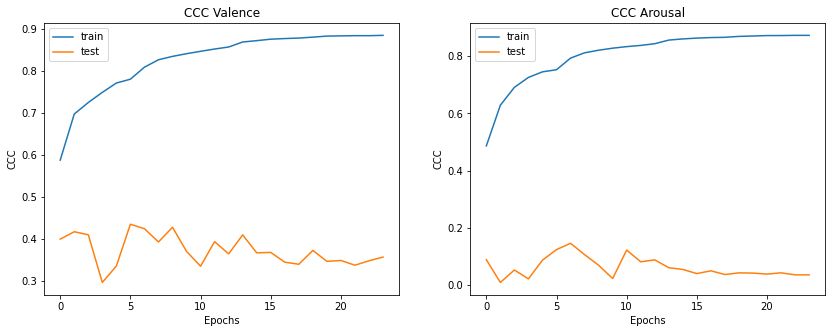

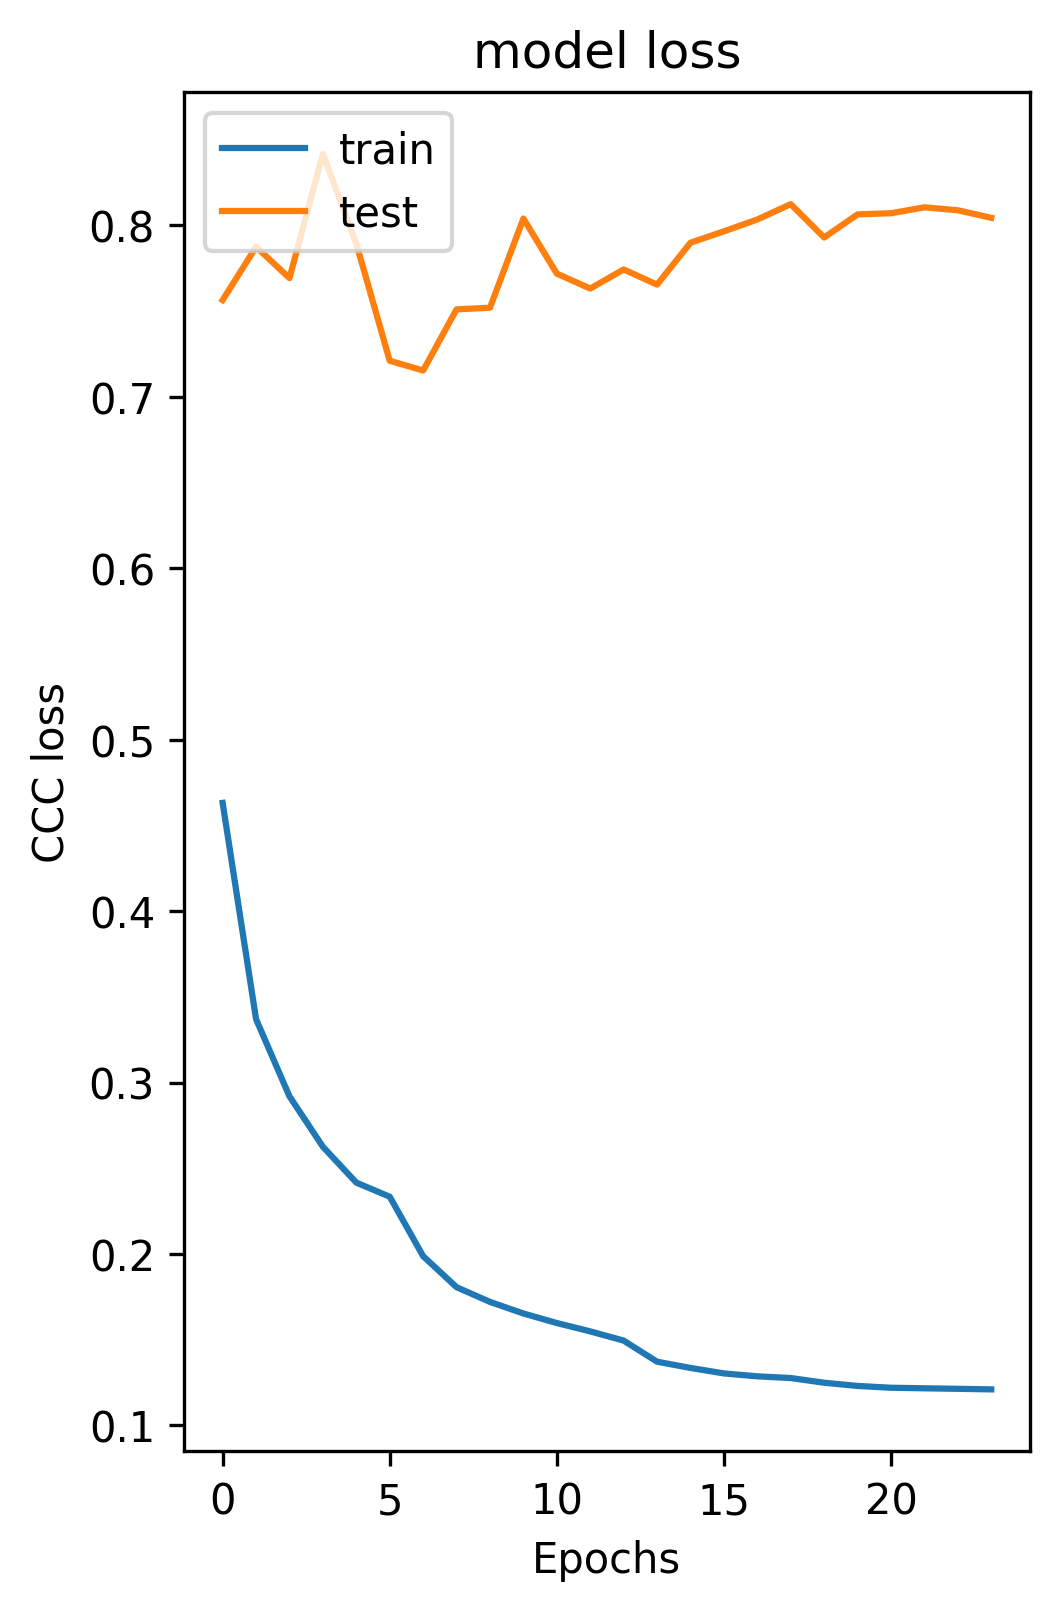

In [ ]:
''' 
  RESULTS VISUALIZATION
''' 

### Results for the model
### PLOTTING OF CCC SCORE
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
 
plt.plot(model.history.history['ccc_v'])
plt.plot(model.history.history['val_ccc_v'])
plt.title('CCC Valence')
plt.xlabel('Epochs')
plt.ylabel('CCC')
plt.legend(['train', 'test'], loc='upper left')
 
plt.subplot(1,2,2)
plt.plot(model.history.history['ccc_a'])
plt.plot(model.history.history['val_ccc_a'])
plt.title('CCC Arousal')
plt.xlabel('Epochs')
plt.ylabel('CCC')
plt.legend(['train', 'test'], loc='upper left')
plt.rcParams['figure.dpi'] = 300
plt.savefig("/content/drive/MyDrive/Colab_Notebooks/omg/omg_alberts_final_va.png")
plt.show()
 
### PLOTTING OF CCC LOSS
### Results for the model
plt.figure(figsize=(8,6))
plt.subplot(1,2,2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.xlabel('Epochs')
plt.ylabel('CCC loss')
plt.legend(['train', 'test'], loc='upper left')
plt.rcParams['figure.dpi'] = 300
plt.savefig("/content/drive/MyDrive/Colab_Notebooks/omg/omg_alberts_loss.png")
plt.show()

In [ ]:
results = model.evaluate(x=test_faces, y=test_labels, batch_size=64)
print("test loss, test acc:", results)